## Imports

In [1]:
%%capture
%pip install matplotlib
%pip install scipy
%pip install PyWavelets
%pip install fbm
%pip install /usr/local/MATLAB/R2024a/extern/engines/python

In [2]:
import numpy as np
import random
import statistics
from statistics import median
import matplotlib.pyplot as plt # Para graficar la distribución
from scipy import stats
import pywt
from fbm import FBM


In [3]:
import matlab.engine

## Funciones necesarias

### pdfcdfcontinua

In [4]:
def pdfcdfcontinua(datos, minimo=None, maximo=None, particiones=None):
    """
    Estima la función de densidad (PDF) y la función de distribución acumulativa (CDF)
    de una muestra aleatoria `datos` usando histogramas.
    """

    datos = np.ravel(datos)
    total = len(datos)

    if minimo is None or maximo is None:
        rango = np.max(datos) - np.min(datos)
        minimo = np.min(datos) - 0.02 * rango
        maximo = np.max(datos) + 0.02 * rango

    print(minimo, maximo)

    if particiones is None:
        particiones = int(np.floor(np.sqrt(total)))

    bins = np.linspace(minimo, maximo, particiones + 1)

    # Histograma normalizado (densidad=True) para obtener PDF
    fr, edges = np.histogram(datos, bins=bins, density=False)
    ancho_bin = edges[1] - edges[0]
    pdf = fr / (total * ancho_bin)

    # CDF como suma acumulativa de las frecuencias normalizadas
    cdf = np.cumsum(fr) / total

    x = edges[:-1] + ancho_bin / 2  # Coordenadas del centro de cada bin

    # Gráficas
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    axs[0].plot(x, pdf, linewidth=2)
    axs[0].set_title("Estimación de la función de densidad")
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$f_X(x)$")
    axs[0].grid(True)

    axs[1].plot(x, cdf, linewidth=2)
    axs[1].set_title("Estimación de la Distribución Acumulativa")
    axs[1].set_xlabel("$x$")
    axs[1].set_ylabel("$F_X(x)$")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

### superfuncion

In [5]:
def superfuncion(datos, nombre='aleatorio'):
    if datos is None or len(datos) == 0:
        print("Falta el vector de datos")
        return

    p = np.linspace(0, 1, 100000)
    datos = 1.0000000001 * np.array(datos).flatten()
    numero = np.quantile(datos, p)

    encabezado = f"def {nombre}(m, n):"
    cuerpo = f"    numero = {numero.tolist()}"
    final = (
        "    import numpy as np\n"
        "    if m == 1:\n"
        "        return np.transpose(np.random.choice(numero, (n,)))\n"
        "    else:\n"
        "        return np.random.choice(numero, (m, n))"
    )

    with open(f"{nombre}.py", "w") as f:
        f.write(encabezado + "\n")
        f.write(cuerpo + "\n")
        f.write(final + "\n")

    print(f"{nombre}.py generado. Revisa tu carpeta actual.")
    print(f"Luego puedes ejecutar: from {nombre} import {nombre}; {nombre}(m,n)")

In [6]:
# BCpAug89
datosAug = np.loadtxt("./BCpAug89.TL")
muestraAgosto = np.diff(datosAug[:, 0])

# BCpOct89
datosOct = np.loadtxt("./BCpOct89.TL")
muestraOctubre = np.diff(datosOct[:, 0])

# BCOct89Ext
datosOctExt = np.loadtxt("./BCOct89Ext.TL")
muestraOctubreExt = np.diff(datosOctExt[:, 0])

# BCOct89Ext4
datosOctExt4 = np.loadtxt("./BCOct89Ext4.TL")
muestraOctubreExt4 = np.diff(datosOctExt4[:, 0])

In [7]:
superfuncion(muestraAgosto, "agostoAleatorio")
superfuncion(muestraOctubreExt4, "octubreExt4Aleatorio")

agostoAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from agostoAleatorio import agostoAleatorio; agostoAleatorio(m,n)
octubreExt4Aleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreExt4Aleatorio import octubreExt4Aleatorio; octubreExt4Aleatorio(m,n)


In [8]:
import agostoAleatorio
import octubreExt4Aleatorio

In [9]:
muestraAgostosf = agostoAleatorio.agostoAleatorio(1, 1000000)
muestraAgostosf

array([0.00122 , 0.00278 , 0.003788, ..., 0.00068 , 0.004056, 0.002336])

In [10]:
muestraOctubreExt4sf = octubreExt4Aleatorio.octubreExt4Aleatorio(1, 1000000)
muestraOctubreExt4sf

array([0.011452  , 0.000948  , 0.004228  , ..., 0.002872  , 0.009496  ,
       0.05931404])

### vt

In [11]:

def _pendienteci(x, y):
    """
    Regresión lineal simple (mínimos cuadrados) y cálculo de intervalo de confianza al 95% para la pendiente.

    Parámetros
    ----------
    x : 1D array
        Variable independiente (log10(m)).
    y : 1D array
        Variable dependiente (log10(varianza)).

    Devuelve
    -------
    m : float
        Pendiente de la recta.
    b : float
        Ordenada al origen de la recta.
    ml : float
        Límite inferior de intervalo de confianza (95%) para m.
    mh : float
        Límite superior de intervalo de confianza (95%) para m.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if n < 3:
        raise ValueError("Se requieren al menos 3 puntos para realizar regresión.")

    # Cálculo de parámetros de la recta: m y b
    A = np.dot(x, x)
    B = x.sum()
    C = np.dot(x, y)

    x_mean = x.mean()
    y_mean = y.mean()

    m = (C - B * y_mean) / (A - B * x_mean)
    b = y_mean - m * x_mean

    # Error residual
    y_pred = m * x + b
    error = y - y_pred
    s = np.sqrt(np.dot(error, error) / (n - 2))

    # Sxx = sum((x - x_mean)^2)
    ex = x - x_mean
    Sxx = np.dot(ex, ex)

    # t critico para 95% en n-2 grados de libertad
    tval = stats.t.ppf(0.975, df=n - 2)

    # Intervalo de confianza para la pendiente m
    ml = m - tval * s / np.sqrt(Sxx)
    mh = m + tval * s / np.sqrt(Sxx)

    return m, b, ml, mh

def vt(traza, plot = False):
    """
    Diagrama Varianza–Tiempo y estimación del parámetro de Hurst.

    Parámetros
    ----------
    traza : array_like, 1D
        Vector de datos (serie de tiempo) sobre el cual se calcula el diagrama varianza–tiempo.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio de la recta).
    Hmin  : float
        Límite inferior del intervalo de confianza al 95% para H.
    Hmax  : float
        Límite superior del intervalo de confianza al 95% para H.

    Además, la función dibuja (en pantalla) el diagrama log10(varianza) vs. log10(m)
    junto con la recta de regresión lineal y su intervalo de confianza.
    """
    traza = np.asarray(traza).flatten()
    L = traza.size

    # gruposmax = fix(L / sqrt(L)) en MATLAB equivale a floor(sqrt(L))
    gruposmax = int(np.floor(np.sqrt(L)))
    if gruposmax < 2:
        raise ValueError("La longitud de 'traza' es demasiado pequeña para calcular vt().")

    # Reservamos un arreglo para varianza; tendrá longitud (gruposmax - 1)
    varianza = np.zeros(gruposmax - 1, dtype=float)

    # Para cada n = 2 ... gruposmax, calculamos:
    #   columnas = fix(L / n)
    #   datos  = reshape(traza(1 : n*columnas), [n, columnas])
    #   varianza(n-1) = var(promedios), donde promedios = mean(datos) (promedio por columna)
    for idx, n in enumerate(range(2, gruposmax + 1)):
        columnas = int(np.floor(L / n))
        if columnas < 1:
            # si columnas=0, no podemos reshape; salir del bucle
            break

        # Reproducimos reshape(..., [n, columnas]) de MATLAB (que rellena por columnas).
        bloque = traza[: n * columnas]
        datos = bloque.reshape((n, columnas), order='F')

        # promedio de cada columna (dim=0) y varianza muestral (ddof=1)
        promedios = datos.mean(axis=0)
        varianza[idx] = np.var(promedios, ddof=1)

    # Tomamos sólo los índices válidos (en caso de que el bucle se haya roto antes)
    Npts = idx + 1
    varianza = varianza[:Npts]

    # Construimos x = log10(m) para m = 2,3,...,2+Npts-1
    m_vals = np.arange(2, 2 + Npts)
    x = np.log10(m_vals)
    y = np.log10(varianza)

    # Regresión lineal con intervalo de confianza
    m_slope, b_intercept, ml, mh = _pendienteci(x, y)

    H     = m_slope / 2 + 1
    Hmin  = ml / 2 + 1
    Hmax  = mh / 2 + 1

    # --- Visualización del diagrama ---
    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))
        # Puntos experimentales
        ax.plot(x, y, 's', markerfacecolor='b', markeredgecolor='k', label=r'$\log S_{X^{(m)}}^2$')

        # Recta de regresión: y_hat = m_slope * x + b_intercept
        y_hat = m_slope * x + b_intercept
        ax.plot(x, y_hat, 'r', linewidth=2, label='Regresión Lineal')

        # Intervalo de confianza (líneas punteadas)
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        # Definimos x1, x2 tal como en MATLAB (0.45 y 0.55 del rango)
        x1 = xmin + 0.45 * (xmax - xmin)
        x2 = xmin + 0.55 * (xmax - xmin)
        y1 = m_slope * x1 + b_intercept
        y2 = m_slope * x2 + b_intercept

        # Dibujamos: una línea vertical en x = x1 desde y1 hasta y2, y luego la horizontal en y = y2 de x1 a x2
        ax.plot([x1, x1, x2], [y1, y2, y2], 'k:', linewidth=2)

        # Ajustes estéticos
        ax.set_title('Diagrama Varianza - Tiempo', fontsize=18)
        ax.set_xlabel(r'$\log m$', fontsize=18)
        ax.set_ylabel(r'$\log S_{X^{(m)}}^2$', fontsize=18)
        ax.grid(True)
        ax.set_xlim(xmin, xmax)
        delta_y = ymax - ymin
        ax.set_ylim(ymin - 0.1 * delta_y, ymax + 0.1 * delta_y)
        ax.tick_params(labelsize=16)
        ax.legend(loc='best', fontsize=14, frameon=False)
        fig.patch.set_facecolor('white')

        plt.show()

    return H, Hmin, Hmax



### ld

In [12]:
def LD(traza, plot = False):
    """
    Diagrama Log–Escala (LD) vía transformada wavelet de Haar.

    Parámetros
    ----------
    traza : array_like, 1D
        Serie de datos (vector) de entrada.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio).
    alpha : float
        Pendiente de la regresión lineal en el diagrama log–escala.

    Además, la función dibuja el diagrama log–escala y la recta de regresión
    entre las octavas j1=2 y j2=N-1 (donde N = floor(log2(len(traza))/2 + 1)).
    """
    # Convertir a 1D de NumPy
    X = np.asarray(traza).flatten()
    L = X.size

    # Parámetros por defecto (versión 2.0)
    wavelet = 'db1'  # Haar
    j1 = 2
    N = int(np.floor(np.log2(L) / 2 + 1))  # floor(log2(length)/2 + 1)
    j2 = N - 1

    # Descomposición wavelet de nivel N
    # coeffs = [cA_N, cD_N, cD_{N-1}, ..., cD_1]
    coeffs = pywt.wavedec(X, wavelet, level=N)

    # Construir vector mu de tamaño N. Sólo usaremos índices 1..N-1
    mu = np.zeros(N, dtype=float)

    # Para i = 1 .. N-1, extraer detalle D_i y calcular mu[i] = mean(abs(D_i)^2)
    #   En pywt, el detalle a nivel i está en coeffs[-i].
    for i in range(1, N):
        D_i = coeffs[-i]
        mu[i] = np.mean(np.abs(D_i)**2)

    # Construir los vectores para graficar:
    #   j_all = 1,2,...,N-1   (longitud N-1)
    #   y_all = log2(mu[1]), log2(mu[2]), ..., log2(mu[N-1])
    j_all = np.arange(1, N)
    y_all = np.log2(mu[1:N])

    # Ajuste lineal (Mínimos Cuadrados) sobre j = j1 .. j2
    js = np.arange(j1, j2 + 1)               # [2, 3, ..., N-1]
    y_vals = np.log2(mu[j1:j2 + 1])          # log2(mu_j) para j=j1..j2

    coef = np.polyfit(js, y_vals, 1)
    alpha = coef[0]
    intercept = coef[1]

    # Cálculo de Hurst
    H = alpha / 2 + 0.5

    # Cálculo de intervalo de confianza para H (95%)
    j = j2 - j1
    nj1 = coeffs[-j1].size

    numer = 2 * (1 - 2**(-j))
    denom = nj1 * (np.log(2)**2) * (1 - 2**(-(j + 1)) * (j**2 + 4) + 2**(-2 * j))
    desviacion = np.sqrt(numer / denom)
    error = 1.9599 * desviacion  # t ≈ 1.96 para 95%

    Hmin = H - error
    Hmax = H + error

    # --- Gráfica del diagrama log–escala ---
    if plot:
        plt.figure(figsize=(8, 5))

        # Puntos experimentales: (j_all, y_all)
        plt.plot(j_all, y_all, 'b.', label=r'$\log_2(\mu_j)$')

        # Recta de regresión sólo sobre el tramo j1..j2
        #   Pero podemos extenderla para que cubra todo j_all.
        x_line = np.array([j_all.min(), j_all.max()])
        y_line = intercept + alpha * x_line
        plt.plot(x_line, y_line, 'r-', linewidth=2, label='Regresión Lineal')

        # Ajustes estéticos
        plt.title('Diagrama Log–Escala (LD)', fontsize=18)
        plt.xlabel(r'Octava $j$', fontsize=16)
        plt.ylabel(r'$y_j = \log_2(\mu_j)$', fontsize=16)
        plt.grid(True)
        plt.tick_params(labelsize=14)
        plt.legend([
            fr'Estimación: $H = {H:.4f}$',
            fr'IC 95\%: {Hmin:.4f} < H < {Hmax:.4f}'
        ], fontsize=12, loc='best')
        plt.gcf().patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()

    return H, alpha


### betamwm

In [13]:
def betamwm(Uoo, n, H):
    """
    Versión en Python de la función MATLAB betamwm:
    
    Parámetros
    ----------
    Uoo : escalar o array-like
        Valor inicial (o vector inicial) de la medida. 
        Si es escalar, se tratará como array de longitud 1.
    n : int
        Número de iteraciones (niveles de la cascada binomial).
    H : float
        Parámetro de Hurst (0 < H < 1).
    
    Retorna
    -------
    traza : numpy.ndarray
        Vector de longitud len(Uoo) * 2**n con la medida multifractal resultante.
    """
    # Asegurarnos de trabajar con un array de NumPy (vector fila)
    traza = np.atleast_1d(Uoo).astype(float).flatten()
    
    # Cálculo de beta según la fórmula de MATLAB:
    #    beta = (2^(2*H - 1) - 1) / (2 - 2^(2*H - 1))
    beta = (2**(2*H - 1) - 1) / (2 - 2**(2*H - 1))
    
    for i in range(1, n+1):
        # 1) Generar 2^(i-1) muestras de Beta(beta, beta)
        m = 2**(i-1)
        b = np.random.beta(beta, beta, size=m)
        
        # 2) Construir el vector p = [b; 1-b] intercalado
        #    En MATLAB: p = [b; 1-b]; p = p(:)';
        #    En Python podemos hacer:
        p = np.empty(2*m, dtype=float)
        p[0::2] = b
        p[1::2] = 1 - b
        
        # 3) Duplicar la traza (concatenar consigo misma)
        #    En MATLAB: traza = [traza; traza]; traza = traza(:)';
        traza = np.concatenate([traza, traza])
        
        # 4) Multiplicar elemento a elemento por p
        traza = traza * p
    
    return traza


### Grafica analisis multifractal

In [14]:
def grafica_analisis_multifractal(dh_m, h_m, tauq_m):
    # 6) Convierte las salidas de matlab.double a NumPy 1D
    dh   = np.array(dh_m).flatten()
    h    = np.array(h_m).flatten()
    tauq = np.array(tauq_m).flatten()

    # 7) Genera el vector de momentos q = -5:5 (MATLAB usa enteros por defecto)
    qs = np.arange(-5, 6)  # 11 valores: [-5, -4, …, +5]

    # 8) Grafica los resultados en Python
    plt.figure(figsize=(10, 4))

    # 8.1) τ(q) vs q
    plt.subplot(1, 2, 1)
    plt.plot(qs, tauq, 'bo-', linewidth=1.5, markersize=0)
    plt.xlabel('$q$', fontsize=12)
    plt.ylabel(r'$\tau(q)$', fontsize=12)
    plt.title('Exponentes de Escala (τ vs q)', fontsize=13)
    plt.grid(True)

    # 8.2) Espectro multifractal D(h) vs h
    plt.subplot(1, 2, 2)
    plt.plot(h, dh, 'ro-', linewidth=1.5, markersize=0)
    plt.xlabel('$h$', fontsize=12)
    plt.ylabel(r'$D(h)$', fontsize=12)
    plt.title('Espectro Multifractal (D vs h)', fontsize=13)
    plt.xlim(0, 1)         # <-- Ajuste del eje x de 0 a 1
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Clasificador mono-multi

In [15]:
def clasificador_fractales(traza, eng, threshold=0.05):
    """
    Clasifica automáticamente una “traza” como monofractal o multifractal,
    usando la función dwtleader de MATLAB via MATLAB Engine.

    Parámetros
    ----------
    traza : array_like
        Vector 1-D con los datos de la señal que quieres analizar.
        Por ejemplo, un numpy.ndarray o lista de Python.
    eng : matlab.engine.MatlabEngine
        Instancia activa del MATLAB Engine en Python. Debe estar conectada
        para poder llamar a `eng.dwtleader(...)`.
    threshold : float, opcional (por defecto=0.05)
        Valor mínimo de ancho del espectro Hölder (Δh = max(h)-min(h))
        para considerar que la señal es verdaderamente multifractal.
        Si Δh < threshold, se considera monofractal.

    Retorna
    -------
    resultado : str
        Cadena ‘monofractal’ o ‘multifractal’ según el ancho del espectro Hölder.
    """

    # 1) Llamamos a dwtleader en MATLAB. Devolvemos dh, h, Cp, tau(q).
    #    Se asume que la firma en MATLAB es:
    #       [dh, h, Cp, tauq] = dwtleader(datos, ...)
    #
    #    Convención en Python: nargout=4 indica cuatro salidas.
    dh_m, h_m, cp_m, tauq_m = eng.dwtleader(traza, nargout=4)

    # 2) Convertimos cada uno a numpy 1-D (de matlab.double a np.array)
    #    Solo necesitamos el vector h para la clasificación.
    h = np.array(h_m).flatten()

    # 3) Calculamos el ancho del espectro Hölder: Δh = max(h) - min(h)
    delta_h = float(np.max(h) - np.min(h))

    # 4) Decidimos en base a Δh y al umbral:
    if delta_h < threshold:
        return 'monofractal'
    else:
        return 'multifractal'

# Actividad 1

## Prueba secuencia discreta

In [16]:
# Parámetros de la distribución uniforme discreta
valor_minimo = 1
valor_maximo = 6
numero_de_muestras = 10000
muestras = np.random.randint(valor_minimo, valor_maximo + 1, size=numero_de_muestras)

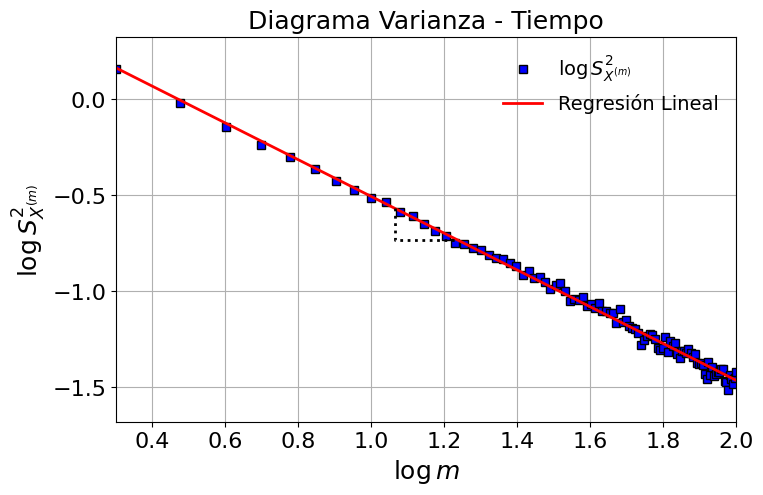

(np.float64(0.5212751323907499),
 np.float64(0.5145857134618456),
 np.float64(0.5279645513196543))

In [17]:
vt(muestras, plot=True)

In [18]:
print(f"Algunas muestras generadas (primeras 20): {muestras[:20]}")
print(f"Valor mínimo generado: {np.min(muestras)}")
print(f"Valor máximo generado: {np.max(muestras)}")

Algunas muestras generadas (primeras 20): [1 4 1 3 1 2 3 2 2 5 3 4 4 3 6 4 2 3 5 2]
Valor mínimo generado: 1
Valor máximo generado: 6


In [19]:
# Calcular la frecuencia de cada número
valores_unicos, conteos = np.unique(muestras, return_counts=True)
for valor, conteo in zip(valores_unicos, conteos):
    print(f"Valor: {valor}, Frecuencia: {conteo}, Probabilidad estimada: {conteo/numero_de_muestras:.4f}")

Valor: 1, Frecuencia: 1599, Probabilidad estimada: 0.1599
Valor: 2, Frecuencia: 1674, Probabilidad estimada: 0.1674
Valor: 3, Frecuencia: 1617, Probabilidad estimada: 0.1617
Valor: 4, Frecuencia: 1711, Probabilidad estimada: 0.1711
Valor: 5, Frecuencia: 1701, Probabilidad estimada: 0.1701
Valor: 6, Frecuencia: 1698, Probabilidad estimada: 0.1698


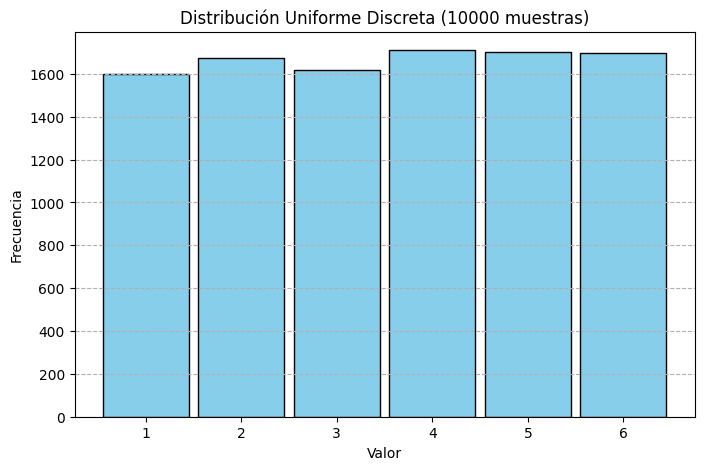

In [20]:
# Graficar el histograma de las muestras para visualizar la distribución
plt.figure(figsize=(8, 5))
plt.bar(valores_unicos, conteos, width=0.9, color='skyblue', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.title(f"Distribución Uniforme Discreta ({numero_de_muestras} muestras)")
plt.xticks(range(valor_minimo, valor_maximo + 1)) # Asegurar que todos los valores del rango aparezcan en el eje x
plt.grid(axis='y', linestyle='--')
plt.show()

## Estimador Diagrama Varianza Tiempo

### Prueba de sesgo

-0.23025706335957816 0.8758832880129613


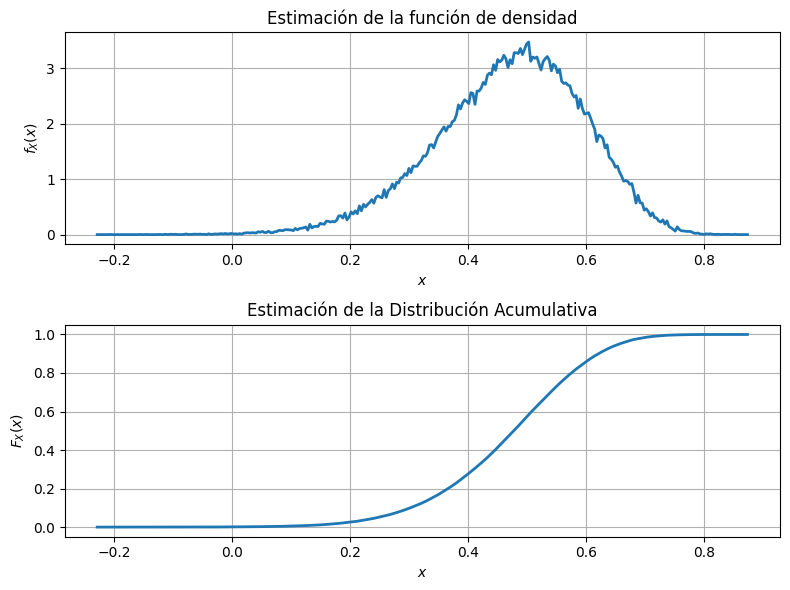

In [ ]:
num_subconjuntos = 100000
num_repeticiones = 100

# la mas optima es la exponencial en ld esta no da sesgo 
subconjuntos = []
for _ in range(num_subconjuntos):
    subconjunto = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    subconjuntos.append(subconjunto)

array_hvt = []
 
for subconjunto in subconjuntos:
    hvt_valores, _, _  = vt(subconjunto)
    array_hvt.append(hvt_valores) 

pdfcdfcontinua(array_hvt)


### Prueba de consistencia

### Prueba de robustez

In [ ]:
num_subconjuntos = 100000
num_repeticiones = 100

subconjuntos_uniforme = []
subconjuntos_exponencial = []
subconjuntos_normales = []

for _ in range(num_subconjuntos):
    subconjunto_uniforme = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    subconjunto_exponencial = np.random.exponential(scale=1.0, size=num_repeticiones)
    subconjunto_normal = np.random.normal(loc=0.0, scale=1.0, size=num_repeticiones)
    subconjuntos_uniforme.append(subconjunto_uniforme)
    subconjuntos_exponencial.append(subconjunto_exponencial)
    subconjuntos_normales.append(subconjunto_normal)

In [ ]:
array_hvt_uniforme = []
array_hvt_exponencial = []
array_hvt_normal = []
 
for subconjunto in subconjuntos_uniforme:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_uniforme.append(hvt_valores) 

for subconjunto in subconjuntos_exponencial:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_exponencial.append(hvt_valores) 

for subconjunto in subconjuntos_normales:
    hvt_valores, _,_  = vt(subconjunto)
    array_hvt_normal.append(hvt_valores) 

### Prueba de eficiencia

## Estimador Diagrama Log Escala

### Prueba de sesgo

/tmp/ipykernel_42421/4178875677.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  desviacion = np.sqrt(numer / denom)


-1.6825601265713808 2.012058318191726


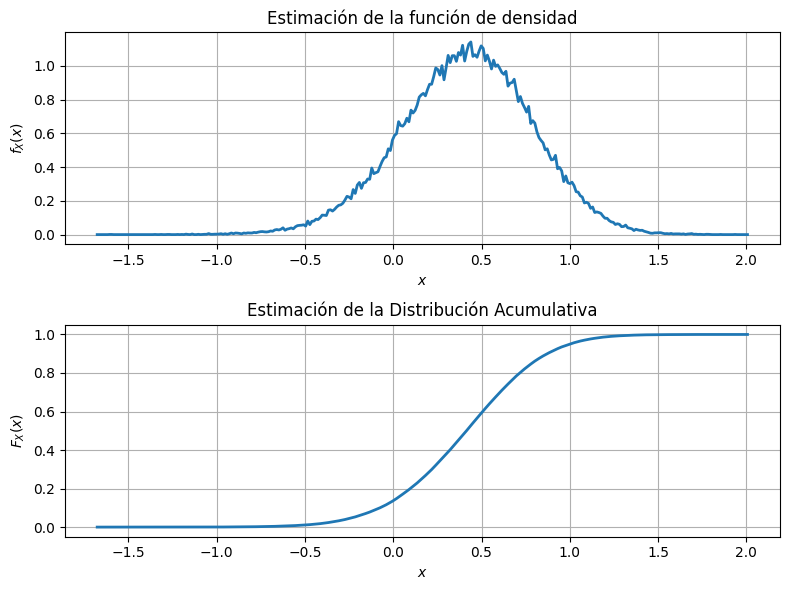

In [28]:
num_subconjuntos = 100000
num_repeticiones = 100  

# la mas optima es la exponencial en ld esta no da sesgo 
subconjuntos = []
for _ in range(num_subconjuntos):
    subconjunto = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    subconjuntos.append(subconjunto)

array_hld = []
 
for subconjunto in subconjuntos:
    hld_valores, _  = LD(subconjunto)
    array_hld.append(hld_valores) 

pdfcdfcontinua(array_hld)

### Prueba de consistencia

### Prueba de robustez

In [31]:
num_subconjuntos = 100000
num_repeticiones = 100

subconjuntos_uniforme = []
subconjuntos_exponencial = []
subconjuntos_normales = []

for _ in range(num_subconjuntos):
    subconjunto_uniforme = np.random.randint(valor_minimo, valor_maximo + 1, size=num_repeticiones)
    subconjunto_exponencial = np.random.exponential(scale=1.0, size=num_repeticiones)
    subconjunto_normal = np.random.normal(loc=0.0, scale=1.0, size=num_repeticiones)
    subconjuntos_uniforme.append(subconjunto_uniforme)
    subconjuntos_exponencial.append(subconjunto_exponencial)
    subconjuntos_normales.append(subconjunto_normal)

In [ ]:
array_hld_uniforme = []
array_hld_exponencial = []
array_hld_normal = []
 
for subconjunto in subconjuntos_uniforme:
    hld_valores, _  = LD(subconjunto)
    array_hld_uniforme.append(hld_valores) 

for subconjunto in subconjuntos_exponencial:
    hld_valores, _  = LD(subconjunto)
    array_hld_exponencial.append(hld_valores) 

for subconjunto in subconjuntos_normales:
    hld_valores, _  = LD(subconjunto)
    array_hld_normal.append(hld_valores) 


pdfcdfcontinua(array_hld_normal)

/tmp/ipykernel_42421/4178875677.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  desviacion = np.sqrt(numer / denom)


### Prueba de eficiencia

# Actividad 4

In [13]:
eng = matlab.engine.start_matlab()
eng.addpath('./matlab_scripts', nargout=0)

## Secuencias monofractales

In [64]:
# Secuencia monofractal
x = 22
N = 2**x
H= 0.8
datos_mono_py = FBM(n=N-1, hurst=H, length=1, method='daviesharte').fbm()
datos_mono_diff_py = np.diff(datos_mono_py)


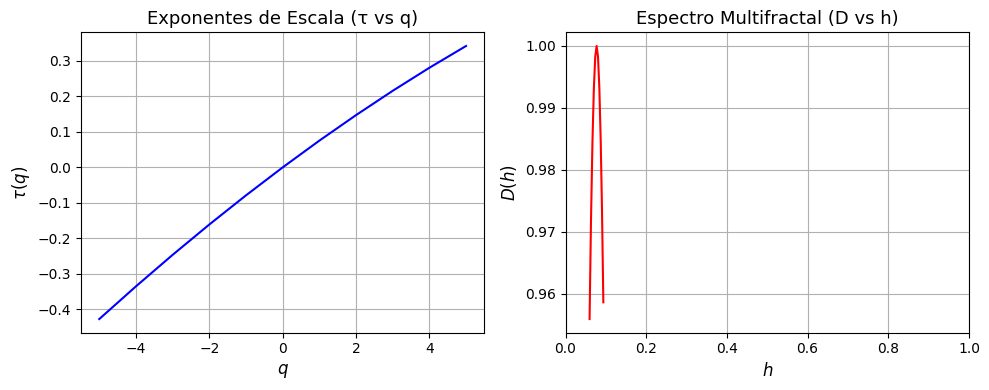

In [65]:
x_matlab = matlab.double(datos_mono_diff_py.tolist())
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(x_matlab, nargout=4)
grafica_analisis_multifractal(dh_m, h_m, tauq_m)


In [74]:
# Secuencia monofractal matlab
H = 0.65             # Hurst (0 < H < 1)
N = 2**22           # tamaño de la fBm: 65536 puntos
length = 1.0        # longitud en “tiempo continuo” (puedes poner 1.0 o el que quieras)
method = 'db4'      # wavelet basis (opcional; MATLAB por defecto usa 'db4' en wfbm)

# 3) Llama a wfbm en MATLAB
#    La sintaxis básica de MATLAB es: y = wfbm(H, N-1, 'wavelet', 'db4');
#    donde y tendrá N puntos. (N-1 porque la función en MATLAB toma 'n' = longitud-1).
fbm_matlab = eng.wfbm(H, float(N-1), method, nargout=1)

# 4) Convertir el resultado a NumPy
datos_mono_matlab = np.array(fbm_matlab).flatten()

# Ahora fbm es un array de longitud N que contiene una trayectoria de fBm monofractal.

# 5) (Opcional) Si lo que necesitas es fGn (señal estacionaria), basta con diferenciar:
datos_mono_diff_matlab = np.diff(datos_mono_matlab)   # longitud N-1

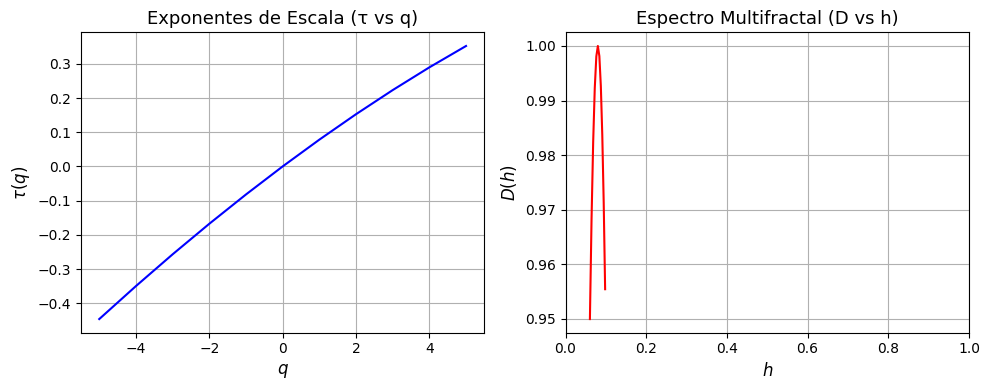

In [75]:
x_matlab = matlab.double(datos_mono_diff_matlab.tolist())

# 5) Llama a dwtleader en MATLAB; pide 4 salidas: dh, h, cp, tauq
#    - dh : vector D(h)
#    - h  : vector h
#    - cp : primeros tres cumulantes
#    - tauq: τ(q) para q = -5:5 (si no indicas otro rango)
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(x_matlab, nargout=4)

grafica_analisis_multifractal(dh_m, h_m, tauq_m)

## Secuencias multifractales

In [68]:
# SIMULACION CON MATLAB
# 3) Prepara los argumentos en Python
Uoo = 1      # puede ser escalar, o lista/array Python
n   = 22         # número de iteraciones de la cascada
H   = 0.95     

# 4) Convertir Uoo a matlab.double. Si Uoo es escalar, basta hacerlo lista de un elemento:
Uoo_matlab = matlab.double([Uoo])   # resultado: un vector 1×1 en MATLAB

# 5) Llamar a la función betamwm en MATLAB
#    nargout=1 porque la función devuelve solo una salida (traza)
traza_matlab = eng.betamwm(Uoo_matlab, n, H, nargout=1)

# 6) Convertir la salida de MATLAB (matlab.double) a NumPy
#    traza_matlab es algo como un 1×(2^n) array de MATLAB; lo llevamos a un array 1D de NumPy
datos_multi_matlab = np.array(traza_matlab).flatten()



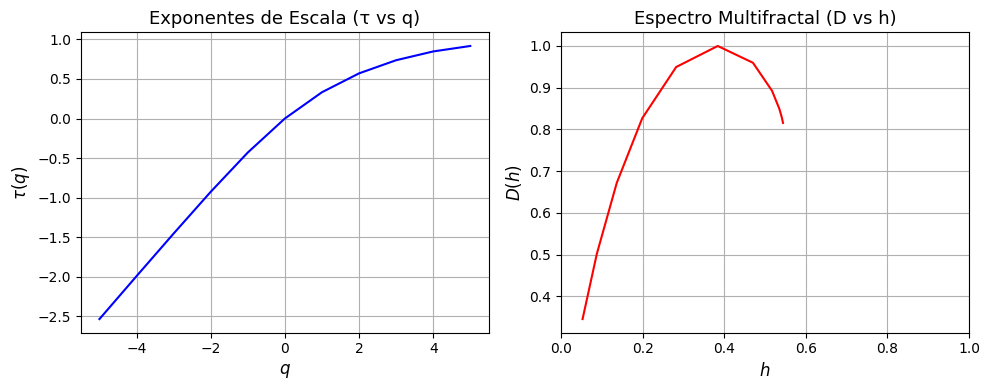

In [69]:
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(datos_multi_matlab, nargout=4)

grafica_analisis_multifractal(dh_m, h_m, tauq_m)

In [71]:
# Simulacion con BETAMWM python
datos_multi_py = betamwm(1,22,0.95)

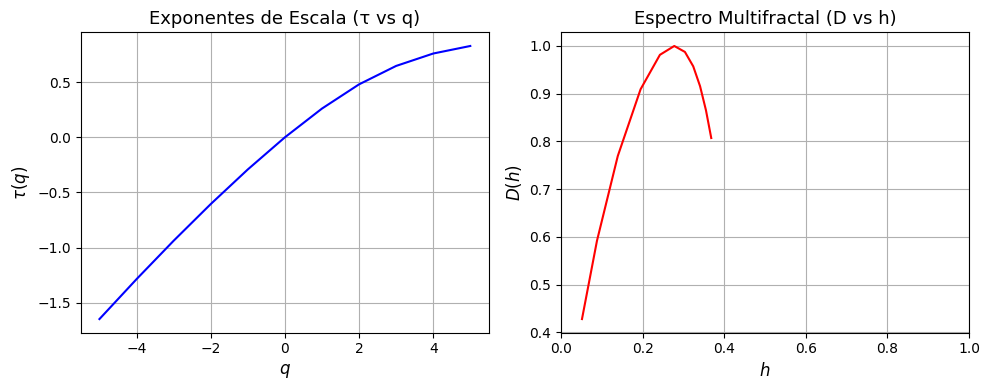

In [72]:
x_matlab = matlab.double(datos_multi_py.tolist())

# 5) Llama a dwtleader en MATLAB; pide 4 salidas: dh, h, cp, tauq
#    - dh : vector D(h)
#    - h  : vector h
#    - cp : primeros tres cumulantes
#    - tauq: τ(q) para q = -5:5 (si no indicas otro rango)
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(x_matlab, nargout=4)
grafica_analisis_multifractal(dh_m, h_m, tauq_m)

In [83]:
print("datos_mono_diff_matlab: "+clasificador_fractales(datos_mono_diff_matlab, eng))
print("datos_mono_diff_py: "+clasificador_fractales(datos_mono_diff_py, eng))
print("datos_multi_matlab: "+clasificador_fractales(datos_multi_matlab, eng))
print("datos_multi_py: "+clasificador_fractales(datos_multi_py, eng))

datos_mono_diff_matlab: monofractal
datos_mono_diff_py: monofractal
datos_multi_matlab: multifractal
datos_multi_py: multifractal


# Pruebas

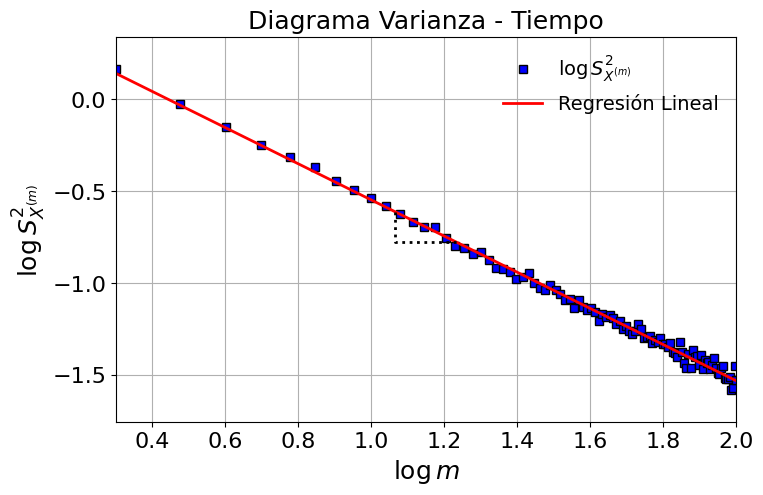

In [ ]:
x, hmin, hmax =  vt(muestras)

In [ ]:
print(x)
print(hmin)
print(hmax)

0.5080823077090608
0.5011584473007057
0.5150061681174158


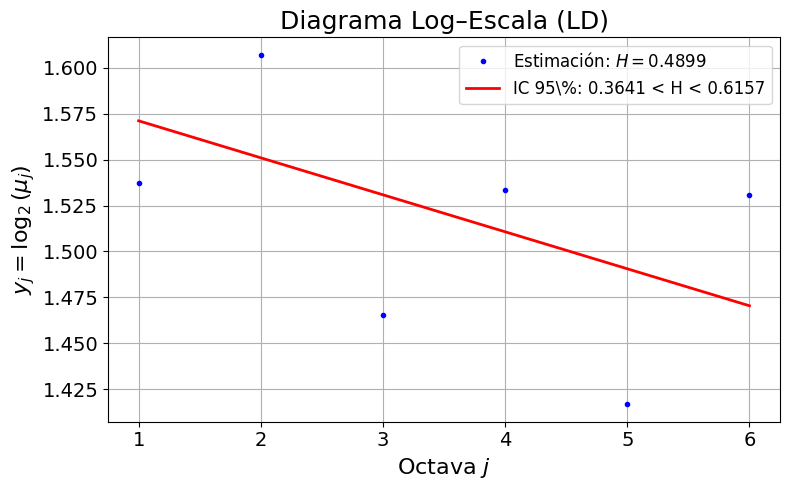

(np.float64(0.4899350471270667), np.float64(-0.020129905745866542))

In [ ]:
LD(muestras)

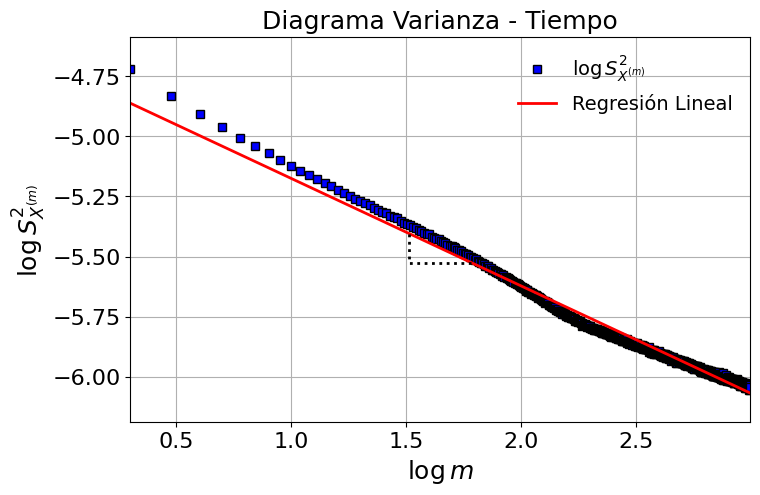

In [ ]:
x, hmin, hmax =  vt(muestraAgosto)

In [ ]:
x, hmin, hmax

(np.float64(0.7766189250779685),
 np.float64(0.7749990979680372),
 np.float64(0.7782387521878998))

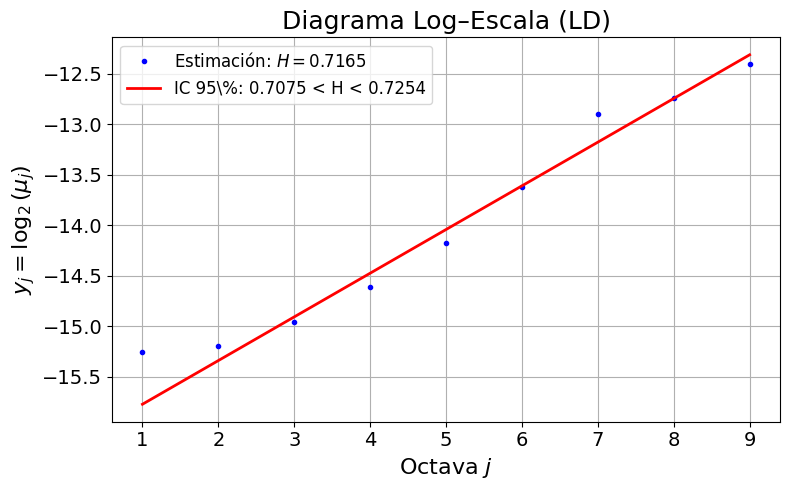

(np.float64(0.7164564323018916), np.float64(0.43291286460378325))

In [ ]:
LD(muestraAgosto)

In [ ]:
datos = betamwm(1,20,0.9)

In [ ]:
len(datos)

1048576

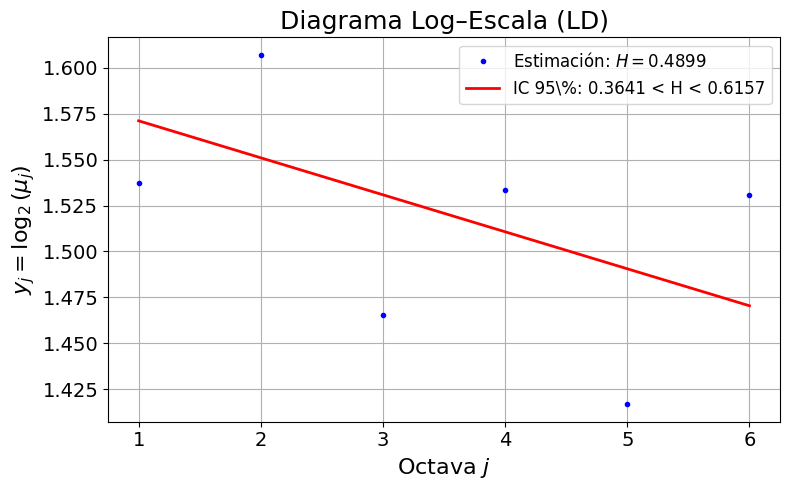

(np.float64(0.4899350471270667), np.float64(-0.020129905745866542))

In [ ]:
LD(muestras)

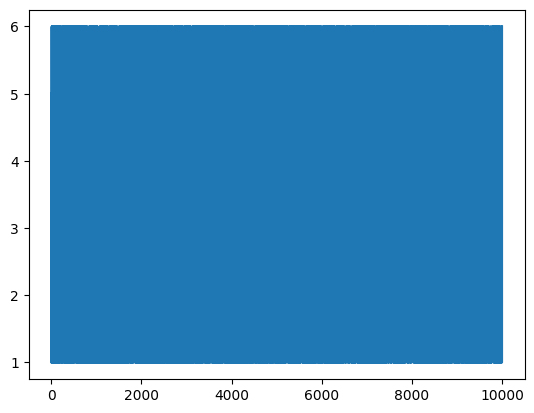

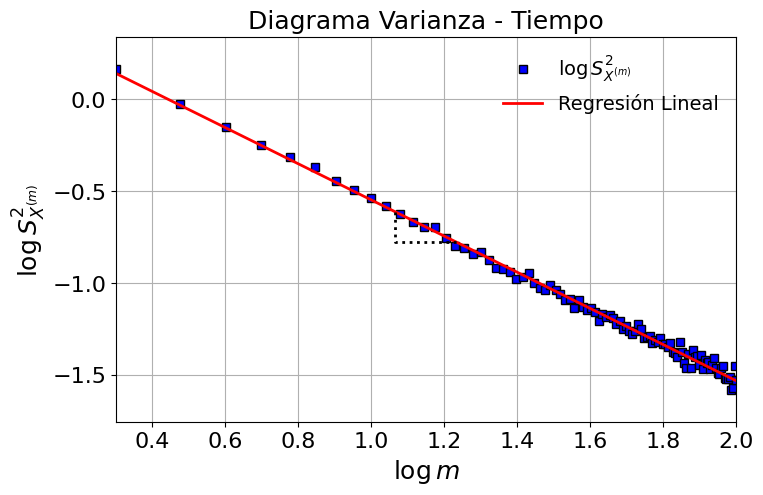

(np.float64(0.5080823077090608),
 np.float64(0.5011584473007057),
 np.float64(0.5150061681174158))

In [ ]:
diffmuestras= np.diff(muestras)
# plt.plot(muestras)
vt(muestras)

In [ ]:
x = 20
N = 2**x
H= 0.8
serie = FBM(n=N-1, hurst=H, length=1, method='daviesharte').fbm()
seriediff = np.diff(serie)

[ 0.00000000e+00 -1.43923796e-06 -1.86708265e-05 ...  1.21905236e+00
  1.21905457e+00  1.21905411e+00]


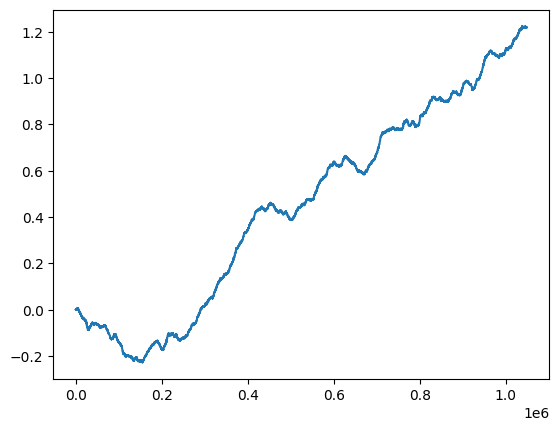

In [ ]:
print(serie)
plt.plot(serie)

[-1.43923796e-06 -1.72315886e-05 -1.43361228e-05 ...  1.77805805e-05
  2.21065594e-06 -4.67884965e-07]


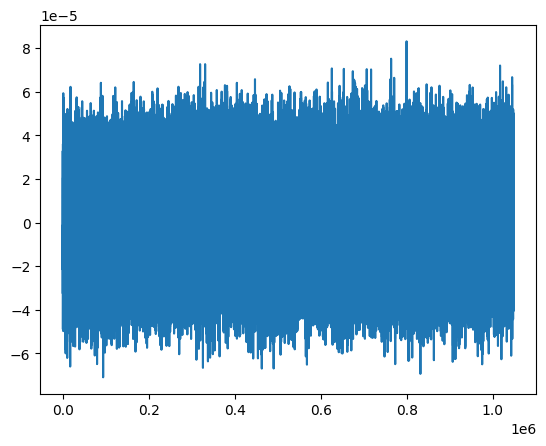

In [ ]:
print(seriediff)
plt.plot(seriediff)

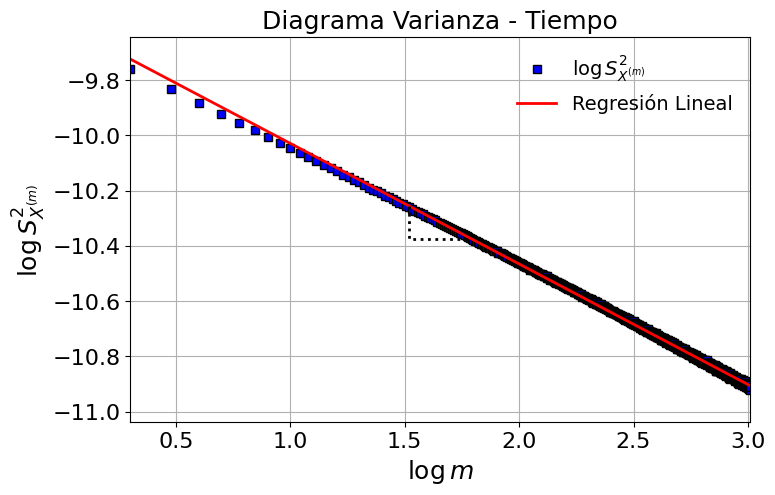

(np.float64(0.7818769130180043),
 np.float64(0.7814808444589681),
 np.float64(0.7822729815770404))

In [ ]:
vt(serie)

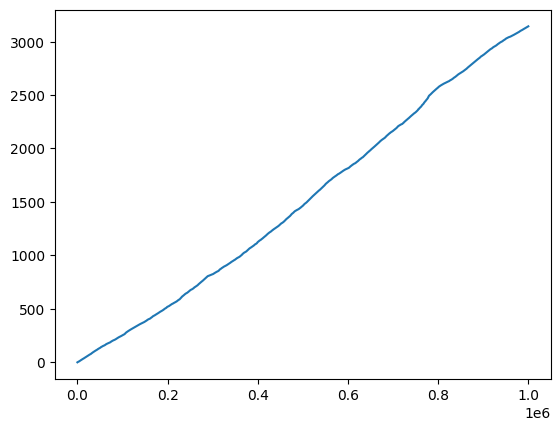

In [38]:
plt.plot(muestraAgosto)

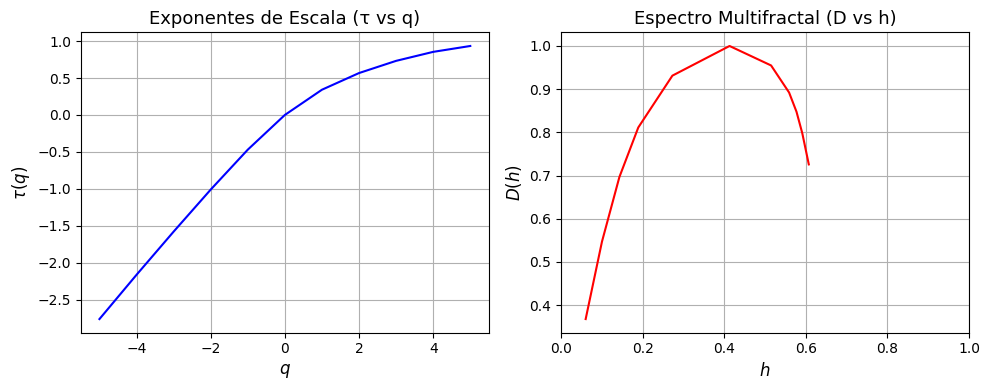

In [52]:
datosAug = np.loadtxt("./BCpAug89.TL")
muestraAgosto = np.diff(datosAug[:, 0])
# muestraAgosto = datosAug[:, 0]

N = 2**14
x_py = np.cumsum(np.random.randn(N))  # genera una fBm simulada en Python

# 4) Convierte la señal de NumPy a matlab.double
#    Nota: matlab.double espera una lista de listas (si es vector fila, basta .tolist()).
x_matlab = matlab.double(muestraAgosto.tolist())

# 5) Llama a dwtleader en MATLAB; pide 4 salidas: dh, h, cp, tauq
#    - dh : vector D(h)
#    - h  : vector h
#    - cp : primeros tres cumulantes
#    - tauq: τ(q) para q = -5:5 (si no indicas otro rango)
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(x_matlab, nargout=4)

# dh_m

# tauq_m


# 6) Convierte las salidas de matlab.double a NumPy 1D
grafica_analisis_multifractal(dh_m, h_m, tauq_m)

# 9) (Opcional) Si ya no vas a usar más MATLAB en esta sesión, ciérralo

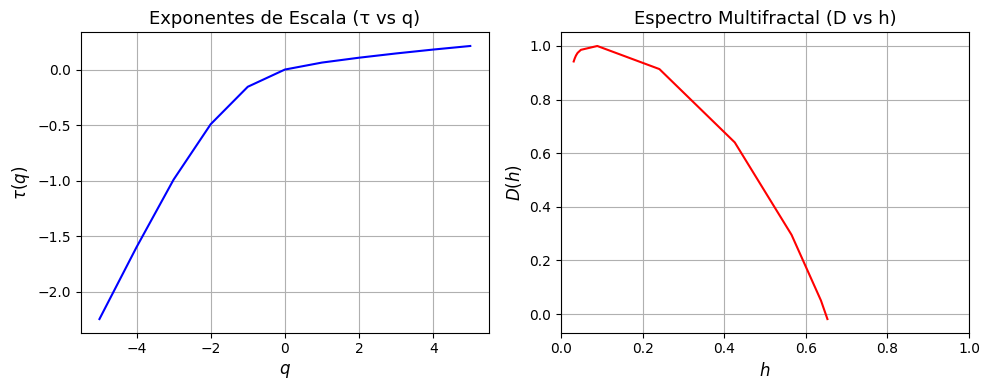

In [51]:
datosAug = np.loadtxt("./BCpAug89.TL")
muestraAgosto = datosAug[:,1]
# muestraAgosto = datosAug[:, 0]

N = 2**14
x_py = np.cumsum(np.random.randn(N))  # genera una fBm simulada en Python

# 4) Convierte la señal de NumPy a matlab.double
#    Nota: matlab.double espera una lista de listas (si es vector fila, basta .tolist()).
x_matlab = matlab.double(muestraAgosto.tolist())

# 5) Llama a dwtleader en MATLAB; pide 4 salidas: dh, h, cp, tauq
#    - dh : vector D(h)
#    - h  : vector h
#    - cp : primeros tres cumulantes
#    - tauq: τ(q) para q = -5:5 (si no indicas otro rango)
dh_m, h_m, cp_m, tauq_m = eng.dwtleader(x_matlab, nargout=4)

# dh_m

# tauq_m


grafica_analisis_multifractal(dh_m, h_m, tauq_m)

# 9) (Opcional) Si ya no vas a usar más MATLAB en esta sesión, ciérralo